In [ ]:
import numpy as np 
import matplotlib.pyplot as plt

# install
## numpy
## matplotlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/MyDrive/Colab Notebooks/assign05

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/Colab Notebooks/assign05


## data load & preprocessing

##### MNIST 손글씨 데이터셋

In [ ]:
from dataset.mnist import load_mnist

(train_raw_img, train_label), (test_raw_img, test_label) = load_mnist(flatten=False, normalize=False)
print(train_raw_img.shape)

(60000, 1, 28, 28)


In [ ]:
# preprocessing (train & inference)

train_img = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
train_label = train_label.reshape(len(train_label), -1)

test_img = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)
test_label = test_label.reshape(len(test_label), -1)

print(train_img.shape)
print(train_label.shape)
print(test_img.shape)
print(test_label.shape)

(60000, 784)
(60000, 1)
(10000, 784)
(10000, 1)


In [ ]:
# normalization (set value 0 ~ 1)

train_img = train_img.astype('float')
train_img = train_img/255

test_img = test_img.astype('float')
test_img = test_img/255

## model

In [ ]:
class Linear :
    def __init__(self, input_size=1, hidden_size=1) :
        self.W = np.random.randn(input_size, hidden_size) # input_size와 hidden_size를 가지는 정규분포를 따르는 난수 생성
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x) :
        self.x = x
        out = np.dot(x, self.W) + self.b  # 입력값(x) * 가중치(W) + Bias(b)
        return out
    
    def backward(self, dout, lr, lamb=0) :
        dx = np.dot(dout, self.W.T) # 입력값에 대한 미분값
        self.dW = np.dot(self.x.T, dout)  # 가중치에 대한 미분값
        self.db = np.sum(dout, axis=0)  # Bias에 대한 미분값
        self.W -= lr * (self.dW + lamb * self.W)  # 학습률(lr)을 통해 가중치 업데이트 (L2 정규화)
        self.b -= lr * self.db  # 학습률(lr)을 통해 Bias 업데이트
        return dx

## [실습 1]

##### Activation Function (Sigmoid, ReLU, Leaky ReLU, TanH)

In [ ]:
# Activation function

class Relu :
    def __init__(self) :
        self.mask =None
    
    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout) :
        dout[self.mask] = 0
        return dout    

class Leaky_Relu :
    def __init__(self) :
        self.mask = None
    
    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] *= 0.01
        return out
    
    def backward(self, dout) :
        dout[self.mask] *= 0.01
        return dout

class Sigmoid :
    def __init__(self) :
        self.out = None
        
    def forward(self, x) :
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout) :
        dx = dout * self.out * (1 - self.out)
        return dx

class TanH :
    def __init__(self) :
        self.out = None
        
    def forward(self, x) :
        self.out = np.tanh(x)
        return self.out

    def backward(self, dout) :
        dx = dout * (1 - self.out**2)
        return dx                                                                                                                                                                                                                                                                                                             

In [ ]:
class Softmax_with_CrossEntropy :
    def __init__(self) :
        # softmax
        self.softmax_x = None 
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        self.delta = 1e-7
        
    def softmax_forward(self, x) :
        self.softmax_x = x
        tmp = np.max(self.softmax_x, axis=1).reshape(-1, 1)
        self.softmax_out = np.exp(self.softmax_x-tmp)/np.sum(np.exp(self.softmax_x-tmp), axis=1).reshape(-1,1)
        return self.softmax_out
    
    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        loss = -np.sum(self.target*np.log(self.pred+self.delta), axis=1)
        return loss
    
    def backward(self) :
        dout = (self.pred-self.target)/len(self.pred)
        return dout

## Train / Eval

In [ ]:
# one_hot label 만드는 함수

def make_one_hot(labels) :
    a = []
    for label in labels :
        one_hot = np.zeros(10)
        one_hot[label] = 1
        a.append(one_hot)
    a = np.array(a)
    return a

# one_hot_labels = make_one_hot(train_label)
# print(train_label[0])
# print(one_hot_labels[0])

In [ ]:
def eval(model, train_version = True) :
    if train_version :
        x = train_img
        labels = train_label.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_img
        labels = test_label.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values() :
        if isinstance(layer, Softmax_with_CrossEntropy) :
            x = layer.softmax_forward(x)
        else :
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

In [ ]:
from collections import OrderedDict

def train_MLP(config) :
    lr, num_epoch = config['learning_rate'], config['num_epoch']
    print_loss_interval = 20
    
    layer1 = Linear(784, 100)
    activation_function = config['activation_function']
    layer2 = Linear(100, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()

    chart = []
    
    for iter in range(num_epoch) :
        # forward
        x = layer1.forward(train_img)
        x = activation_function.forward(x)
        x = layer2.forward(x)
        preds = softmax_with_CE.softmax_forward(x)
        
        # loss
        one_hot_labels = make_one_hot(train_label)
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        # backward
        dL = softmax_with_CE.backward()
        dL = layer2.backward(dL, lr)
        dL = activation_function.backward(dL)
        dL = layer1.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
        
        chart.append(loss)

    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE
    
    return model, chart

In [ ]:
config1 = { 'learning_rate' : 0.1,
            'num_epoch' : 100,
            'activation_function' : Relu()
          }

config2 = { 'learning_rate' : 0.1,
            'num_epoch' : 100,
            'activation_function' : Leaky_Relu()
          }

config3 = { 'learning_rate' : 0.1,
            'num_epoch' : 100,
            'activation_function' : Sigmoid()
          }

config4 = { 'learning_rate' : 0.1,
            'num_epoch' : 100,
            'activation_function' : TanH()
          }


print('---ReLU---')
model1, chart_R = train_MLP(config1)

print('\n---Leaky_Relu---')
model2, chart_LR = train_MLP(config2)

print('\n---Sigmoid---')
model3, chart_S = train_MLP(config3)

print('\n---TanH---')
model4, chart_T = train_MLP(config4)


---ReLU---
[epoch 1 / 100] average loss : 14.515890
[epoch 20 / 100] average loss : 5.402407
[epoch 40 / 100] average loss : 3.819308
[epoch 60 / 100] average loss : 3.143301
[epoch 80 / 100] average loss : 2.746464
[epoch 100 / 100] average loss : 2.478938

---Leaky_Relu---
[epoch 1 / 100] average loss : 13.625482
[epoch 20 / 100] average loss : 4.891341
[epoch 40 / 100] average loss : 3.565887
[epoch 60 / 100] average loss : 2.990403
[epoch 80 / 100] average loss : 2.643096
[epoch 100 / 100] average loss : 2.401661

---Sigmoid---
[epoch 1 / 100] average loss : 7.490208
[epoch 20 / 100] average loss : 4.824343
[epoch 40 / 100] average loss : 3.854444
[epoch 60 / 100] average loss : 3.230276
[epoch 80 / 100] average loss : 2.788875
[epoch 100 / 100] average loss : 2.465249

---TanH---
[epoch 1 / 100] average loss : 11.221377
[epoch 20 / 100] average loss : 7.377220
[epoch 40 / 100] average loss : 5.403895
[epoch 60 / 100] average loss : 4.339044
[epoch 80 / 100] average loss : 3.671512

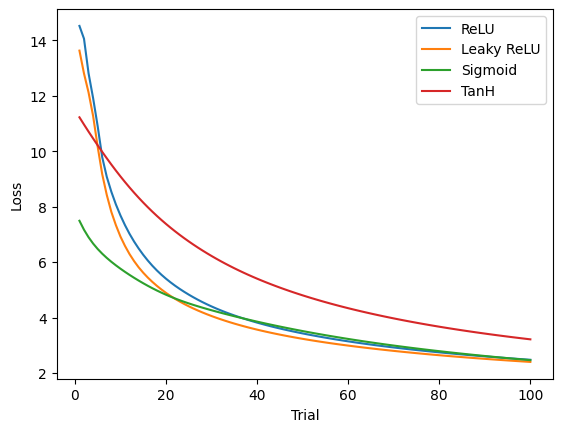

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plt

y_R = chart_R
y_LR = chart_LR
y_S = chart_S
y_T = chart_T
x = [i for i in range(1, 101)]
plt.plot(x, y_R)
plt.plot(x, y_LR)
plt.plot(x, y_S)
plt.plot(x, y_T)
plt.ylabel('Loss')
plt.xlabel('Trial')

plt.legend(['ReLU', 'Leaky ReLU', 'Sigmoid', 'TanH'])

plt.show()


감소 폭이 가장 큰 것은 ReLU이고, 처음 Loss가 가장 작게 나오는 것은 Sigmoid이다.

ReLU는 입력값이 0보다 작으면 0, 크면 입력값 그대로를 출력하기 때문에 계산이 빠르다.

Leaky ReLY는 0이 아닐 때 입력값 자체가 아니라 작은 값을 출력하여 ReLU보다는 약간씩 낮은 값이 출력되지만, 계산량과 시간이 늘어난다.

SIgmoid 함수는 입력값을 0~1로 변환한다.

TanH 함수는 입력값을 -1~1로 변환한다.

Sigmoid 값이 Loss가 적은 반면, TanH는 출력값 평균이 0에 가까워 Accuracy가 더 높게 나온다

In [ ]:
# evaluation

print('\t Accuracy :', eval(model1, train_version=False))
print('\t Accuracy :', eval(model2, train_version=False))
print('\t Accuracy :', eval(model3, train_version=False))
print('\t Accuracy :', eval(model4, train_version=False))


In test dataset ... 
	 Accuracy : 0.7897

In test dataset ... 
	 Accuracy : 0.8013

In test dataset ... 
	 Accuracy : 0.4103

In test dataset ... 
	 Accuracy : 0.5427


## [실습 2]

##### MNIST 손글씨 모델에 다양한 Gradient Descent 방식으로 학습

##### Batch GD, Stochastic GD, Mini-batch GD

In [ ]:
from collections import OrderedDict

def train_MLP_v2(config) :
    lr, num_epoch, batch_size = config['learning_rate'], config['num_epoch'], config['batch_size']
    print_loss_interval = 5

    layer1 = Linear(784, 100)
    activation_function = config['activation_function']
    layer2 = Linear(100, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()

    chart = []

    for iter in range(num_epoch) :
        if batch_size == len(train_img) : # Batch Gradient Descent
          x = layer1.forward(train_img)
          one_hot_labels = make_one_hot(train_label)
        else :  # Mini-batch or Stochastic Gradient Descent
          indices = np.random.choice(len(train_img), batch_size, replace = False)
          x = layer1.forward(train_img[indices])
          one_hot_labels = make_one_hot(train_label[indices])

        x = activation_function.forward(x)
        x = layer2.forward(x)
        preds = softmax_with_CE.softmax_forward(x)

        # loss
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        # backward
        dL = softmax_with_CE.backward()
        dL = layer2.backward(dL, lr)
        dL = activation_function.backward(dL)
        dL = layer1.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
            
        chart.append(loss)
        
    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE
    
    return model, chart

Batch GD : 전체 학습 데이터의 Gradient를 평균에서 Gradient Descent 매번의 step 마다 적용

Stochastic GD : 데이터셋이 큰 경우 전체를 학습하면 메모리 사용이 커지므로, 하나의 데이터를 골라 학습 (확률론적, 불확실성 개념 도입)

Mini-batch GD : 두 방법의 절충안, 전체 학습 데이터를 Mini-batch로 나누어 진행

In [ ]:
print('---batch---')
config_batch = { 'learning_rate' : 0.1,
            'num_epoch' : 20,
            'activation_function' : Relu(),
            'batch_size' : len(train_img)
          }
model_batch, chart_batch = train_MLP_v2(config_batch)


print('\n---mini_batch---')
config_mini_batch = { 'learning_rate' : 0.1,
            'num_epoch' : 20,
            'activation_function' : Relu(),
            'batch_size' : 3 # fill the mini_batch size
          }
model_mini_batch, chart_mb = train_MLP_v2(config_mini_batch)

print('\n---stochastic---')
config_stochastic = { 'learning_rate' : 0.1,
            'num_epoch' : 20,
            'activation_function' : Relu(),
            'batch_size' : 1
          }
model_stochastic, chart_st = train_MLP_v2(config_stochastic)

---batch---
[epoch 1 / 20] average loss : 14.363430
[epoch 5 / 20] average loss : 10.768744
[epoch 10 / 20] average loss : 7.285643
[epoch 15 / 20] average loss : 5.821648
[epoch 20 / 20] average loss : 5.020525

---mini_batch---
[epoch 1 / 20] average loss : 16.118096
[epoch 5 / 20] average loss : 16.118096
[epoch 10 / 20] average loss : 5.372699
[epoch 15 / 20] average loss : -0.000000
[epoch 20 / 20] average loss : 10.453969

---stochastic---
[epoch 1 / 20] average loss : 16.118095
[epoch 5 / 20] average loss : 16.118096
[epoch 10 / 20] average loss : 7.537905
[epoch 15 / 20] average loss : 16.117323
[epoch 20 / 20] average loss : 4.512469


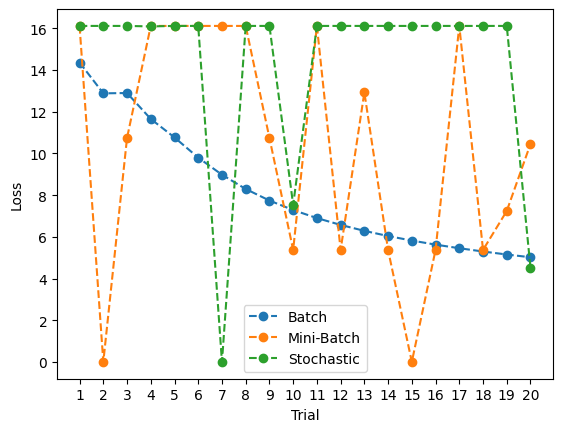

In [ ]:
import matplotlib as mpl
import matplotlib.pylab as plt

y_batch = chart_batch
y_mb = chart_mb
y_st = chart_st
x = [str(i) for i in range(1, 21)]
plt.plot(x, y_batch, linestyle='--', marker='o')
plt.plot(x, y_mb, linestyle='--', marker='o')
plt.plot(x, y_st, linestyle='--', marker='o')
plt.ylabel('Loss')
plt.xlabel('Trial')

plt.legend(['Batch', 'Mini-Batch', 'Stochastic'])

plt.show()


Stochastic GD는 빠른 속도로 수렴하는 장점이 있지만, 노이즈가 많아 데이터에서 수렴이 불안정하다는 특징이 있다. 이 때문에 Accuracy가 가장 낮게 나왔다.

반면 Batch Gradient Descent는 전체 데이터셋을 사용하 업데이트 했으므로 안정적으로 수렴하지만 메모리가 부족하면 사용 불가능하다. 또한 Accuracy가 가장 높다

In [ ]:
print('\t Accuracy :', eval(model_batch, train_version=False))
print('\t Accuracy :', eval(model_mini_batch, train_version=False))
print('\t Accuracy :', eval(model_stochastic, train_version=False))


In test dataset ... 
	 Accuracy : 0.6244

In test dataset ... 
	 Accuracy : 0.3587

In test dataset ... 
	 Accuracy : 0.292


## Extra problem 1

##### 앞서 문제에서 Cross Entropy가 아니라 Multi-class SVM을 구현하라

In [ ]:
class MSVM :
    def __init__(self) :
        self.margins = None
        self.loss = None
        self.target = None
        
    def forward(self, pred, target) :
        num_classes = pred.shape[1]
        num_samples = pred.shape[0]
        self.target = target
        # 마진 계산을 미리 수행하여 self.margins에 저장 (RAM 사용 감소)
        self.margins = np.maximum(0, pred - pred[np.arange(num_samples), target].reshape(-1, 1) + 1)
        self.margins[np.arange(num_samples), target] = 0
        # 손실 계산 (루프 없이 numpy 연산 사용하여 속도 향상)
        loss = np.mean(np.sum(self.margins, axis=1))
        self.loss = loss
        return self.loss
    
    def backward(self) :
        num_classes = self.margins.shape[1]
        num_samples = self.margins.shape[0]
        d_pred = np.zeros_like(self.margins)
        # 마진이 양수인 경우에만 Gradient를 1로 설정 (numpy 연산 사용하여 속도 향상)
        d_pred[self.margins > 0] = 1
        # 타겟값에 해당하는 클래스의 Gradient 계산
        d_pred[np.arange(num_samples), self.target] -= np.sum(d_pred, axis=1)
        d_pred /= num_samples
        return d_pred

In [ ]:
from collections import OrderedDict

def train_MSVM(config) :
    lr = config['learning_rate']
    num_epoch = config['num_epoch']
    activation_function = config['activation_function']
    
    print_loss_interval = 20

    layer1 = Linear(784, 100)
    activation_function = config['activation_function']
    layer2 = Linear(100, 10)
    msvm = MSVM()

    for iter in range(num_epoch):
        # forward
        x = layer1.forward(train_img)
        x = activation_function.forward(x)
        x = layer2.forward(x)
        preds = x
        
        # loss
        targets = train_label
        loss = msvm.forward(preds, targets)
        
        # backward
        dL = msvm.backward()
        dL = layer2.backward(dL, lr)
        dL = activation_function.backward(dL)
        dL = layer1.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
    
    model = OrderedDict()
    model['layer1'] = layer1
    model['activation_function'] = activation_function
    model['layer2'] = layer2
    model['msvm'] = msvm

    return model

In [ ]:
config = { 'learning_rate' : 0.1,
            'num_epoch' : 100,
            'activation_function' : Sigmoid()
          }

model = train_MSVM(config)

In [ ]:
print('\t Accuracy :', eval(model, train_version=False))

메모리 누수로 인해 실행되지 못하는 경우가 많았다. 이에 대한 원인은 데이터셋의 크기가 크기 때문이다.

Multi-class SVM은 마진을 계산하고, 손실은 각 샘플의 마진 값들의 합으로 정의되므로 마진이 0보다 작은 경우만 손실이 발생한다.

Cross Entropy는 예측값과 실제 타겟 값 사이 차이를 비교하여 손실을 계산하는 직관적인 방법이다.

때문에 Multi-class SVM은 클래스 불균형이 있는 경우 클래스별로 가중치를 조절하여 해결하지만, Cross Entropy는 자체에 가중치를 적용하여 해결할 수 있다.

Multi-class SVM은 마진을 기준으로 손실을 계산하고, 미분 가능이 없는 단점이 있지만 클래스 불균형 처리에 유리하다.

Cross Entropy는 예측값과 타겟값의 차이를 사용하여 미분 가능하여 일반적인 최적화 알고리즘에 사용하기 쉬운 장점이 있지만, 클래스 불균형 처리에 불리하다는 단점도 있다.